## HelpMate AI Project

In [1]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:0

In [2]:
# Import all the required libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
from sentence_transformers import SentenceTransformer, util, CrossEncoder


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Read, Process PDF File



In [4]:
# Define PDF path
pdf_path = "/content/drive/MyDrive/HelpMate AI/Principal-Sample-Life-Insurance-Policy.pdf"

#### Reading a single PDF file and exploring it through pdfplumber

In [5]:
# Open the PDF file and print the text
with pdfplumber.open(pdf_path) as pdf:

    single_page = pdf.pages[4]
    text = single_page.extract_text()
    tables = single_page.extract_tables()
    print(text)

PRINCIPAL LIFE INSURANCE COMPANY
(called The Principal in this Group Policy)
Des Moines, Iowa 50392-0002
This group insurance policy is issued to:
RHODE ISLAND JOHN DOE
(called the Policyholder in this Group Policy)
The Date of Issue is November 1, 2007.
In return for the Policyholder's application and payment of all premiums when due, The Principal
agrees to provide:
MEMBER LIFE INSURANCE
MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE
DEPENDENT LIFE INSURANCE
subject to the terms and conditions described in this Group Policy.
GROUP POLICY NO. GL S655
RENEWABLE TERM - NON-PARTICIPATING
CONTRACT STATE OF ISSUE: RHODE ISLAND
This policy has been updated effective January 1, 2014
GC 6000 TITLE PAGE


In [6]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [7]:
# Function to extract text from a PDF file.
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

* Now that we have defined the function for extracting the text

In [8]:

# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {pdf_path}")

extracted_text = extract_text_from_pdf(pdf_path)
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
data.append(extracted_text_df)
print(f"Finished processing {pdf_path}")
print("PDF have been processed.")

...Processing /content/drive/MyDrive/HelpMate AI/Principal-Sample-Life-Insurance-Policy.pdf
Finished processing /content/drive/MyDrive/HelpMate AI/Principal-Sample-Life-Insurance-Policy.pdf
PDF have been processed.


In [9]:
# print the text
data

[   Page No.                                          Page_Text
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
 1    Page 2                 This page left blank intentionally
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
 3    Page 4                 This page left blank intentionally
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
 ..      ...                                                ...
 59  Page 60  I f a Dependent who was insured dies during th...
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...
 61  Page 62  A claimant may request an appeal of a claim de...
 62  Page 63                 This page left blank intentionally
 63  Page 64  Principal Life Insurance Company Des Moines, I...
 
 [64 rows x 2 columns]]

In [10]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [11]:
# print Page No. and Page_Text from the dataframe
insurance_pdfs_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 4,This page left blank intentionally
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...,...
59,Page 60,I f a Dependent who was insured dies during th...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...
61,Page 62,A claimant may request an appeal of a claim de...
62,Page 63,This page left blank intentionally


In [12]:
# Store the metadata for each page in a separate column, now we can consider the Page_No is the metadata
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Page_No.': x['Page No.']}, axis=1)
insurance_pdfs_data

,Page No.,Page_Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'}
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'}
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'}
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'}
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'}
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'}
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'}
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'}
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'}


In [14]:
# Check one of the extracted page texts to ensure that the text has been correctly read
insurance_pdfs_data.Page_Text[4]

"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND This policy has been updated effective January 1, 2014 GC 6000 TITLE PAGE"

In [16]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [18]:
# print the page length
insurance_pdfs_data.sort_values(by="Text_Length", ascending=False)

,Page No.,Page_Text,Metadata,Text_Length
29,Page 30,"(6) If, on the date a Member becomes eligible ...",{'Page_No.': 'Page 30'},462
32,Page 33,a . In no event will Dependent Life Insurance ...,{'Page_No.': 'Page 33'},460
30,Page 31,Scheduled Benefit in force for the Member befo...,{'Page_No.': 'Page 31'},449
31,Page 32,(1) marriage or establishment of a Civil Union...,{'Page_No.': 'Page 32'},429
47,Page 48,c . If a beneficiary dies at the same time or ...,{'Page_No.': 'Page 48'},420
...,...,...,...,...
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'},30
63,Page 64,"Principal Life Insurance Company Des Moines, I...",{'Page_No.': 'Page 64'},8
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'},5
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'},5


##  Document Chunking
#### As the number of words per page is not much so we are using pagewise chunking

## Generating Embeddings </font>

#### Encoding Pipeline
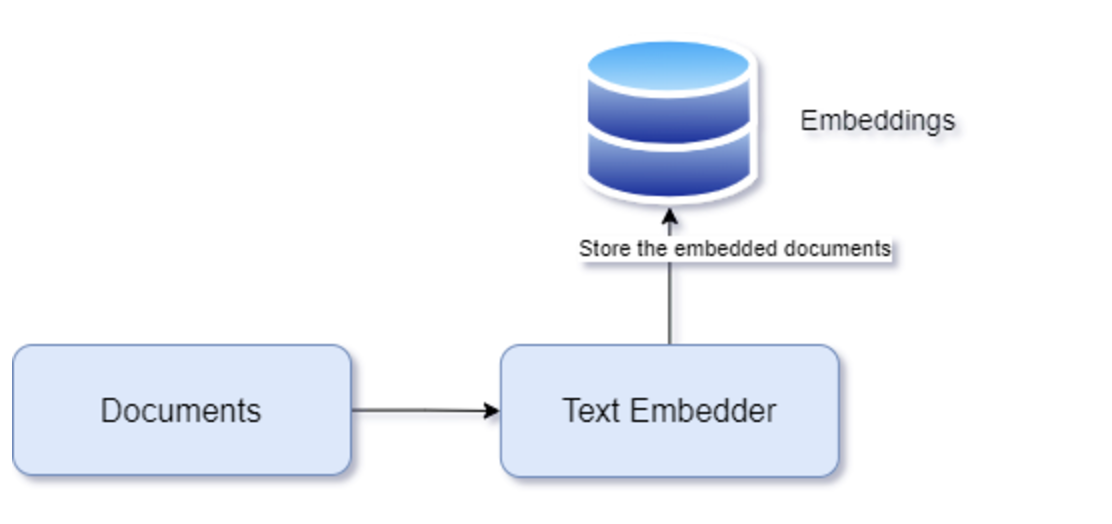

In [19]:
# Load the embedding model
model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=False)
    return embeddings

In [21]:
# function to generate embedding on dataframe
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Page_Text'].apply(lambda x: generate_embeddings([x])[0])

In [22]:
# Create embeddings for 'Chunk Text' column on all three dataframes
generate_embeddings_on_df(insurance_pdfs_data)

In [23]:
# print the dataframe
insurance_pdfs_data

,Page No.,Page_Text,Metadata,Text_Length,Embeddings
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'},30,"[-0.025921896, 0.04777749, 0.05585775, 0.04239..."
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'},5,"[0.029118983, 0.060574077, 0.046415307, 0.0377..."
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'},230,"[-0.10579571, -0.00053022936, 0.01657757, -0.0..."
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'},5,"[0.029118983, 0.060574077, 0.046415307, 0.0377..."
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'},110,"[-0.06354085, 0.05870157, 0.07262772, -0.02723..."
...,...,...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'},285,"[-0.057750396, 0.10381126, -0.036030613, -0.08..."
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'},418,"[-0.102054626, 0.116168015, 0.10008166, -0.012..."
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'},322,"[-0.07275941, 0.11313306, 0.055437688, -0.0776..."
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'},5,"[0.029118983, 0.060574077, 0.046415307, 0.0377..."


## Store Embeddings in ChromaDB

In this section we will store embedding in ChromaDB collection.

In [24]:
# Define the path where chroma collections will be stored
chroma_data_path = '/content/drive/MyDrive/HelpMate AI/'

In [25]:
# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [26]:
# Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.
collection = client.get_or_create_collection(name="insurance-collection")

In [27]:
collection.add(
    embeddings = insurance_pdfs_data['Embeddings'].to_list(),
    documents = insurance_pdfs_data['Page_Text'].to_list(),
    metadatas = insurance_pdfs_data['Metadata'].to_list(),
    ids = [str(i) for i in range(0, len(insurance_pdfs_data['Embeddings']))]
)

In [28]:
# get few of data by ids from collection
collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.0259219 ,  0.04777749,  0.05585775, ..., -0.04932665,
         -0.05851149,  0.02355204],
        [ 0.02911898,  0.06057408,  0.04641531, ...,  0.05954009,
         -0.02838372,  0.00531935],
        [-0.10579571, -0.00053023,  0.01657757, ..., -0.03772428,
          0.03662254, -0.04041128]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'This page left blank intentionally',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other

In [29]:
# create a cache collection
cache_collection = client.get_or_create_collection(name='insurance-collection-cache')

In [30]:
# peek few of elements from cache collection
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [31]:
# Read the user query
query = input()

How many days of grace period is allowed


In [32]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 78.1MiB/s]


In [33]:
# get result from cache collection
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [34]:
# get result from main collection
results = collection.query(
query_texts=query,
n_results=10
)
print("Result size is : " + str(len(results.items())))
results.items()

Result size is : 8


dict_items([('ids', [['19', '22', '42', '32', '25', '35', '27', '20', '37', '29']]), ('embeddings', None), ('documents', [['Section B - Premiums Article 1 - Payment Responsibility; Due Dates; Grace Period The Policyholder is responsible for collection and payment of all premiums due while this Group Policy is in force. Payments must be sent to the home office of The Principal in Des Moines, Iowa. The first premium is due on the Date of Issue of this Group Policy. Each premium thereafter will be due on the first of each Insurance Month. Except for the first premium, a Grace Period of 31 days will be allowed for payment of premium. "Grace Period" means the first 31-day period following a premium due date. The Group Policy will remain in force until the end of the Grace Period, unless the Group Policy has been terminated by notice as described in PART II, Section C. The Policyholder will be liable for payment of the premium for the time this Group Policy remains in force during the Grace 

In [35]:
# Implementing Cache in Semantic Search

threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()



if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      results = collection.query(
      query_texts=query,
      n_results=10
      )

      Keys = []
      Values = []

      size = len(results.items())

      for key, val in results.items():
        if val is None:
          continue
        for i in range(size):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df



elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [36]:
# print the results
results_df

,Metadatas,Documents,Distances,IDs
0,{'Page_No.': 'Page 20'},Section B - Premiums Article 1 - Payment Respo...,1.082573,19
1,{'Page_No.': 'Page 23'},Section C - Policy Termination Article 1 - Fai...,1.185528,22
2,{'Page_No.': 'Page 43'},Any individual policy issued will then be in f...,1.217720,42
3,{'Page_No.': 'Page 33'},a . In no event will Dependent Life Insurance ...,1.249541,32
4,{'Page_No.': 'Page 26'},PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,1.267903,25
5,{'Page_No.': 'Page 36'},A Member's insurance under this Group Policy f...,1.295481,35
6,{'Page_No.': 'Page 28'},Section B - Effective Dates Article 1 - Member...,1.299358,27
7,{'Page_No.': 'Page 21'},b . on any date the definition of Member or De...,1.316056,20
8,{'Page_No.': 'Page 38'},Section D - Continuation Article 1 - Member Li...,1.319336,37
9,{'Page_No.': 'Page 30'},"(6) If, on the date a Member becomes eligible ...",1.325359,29


## Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

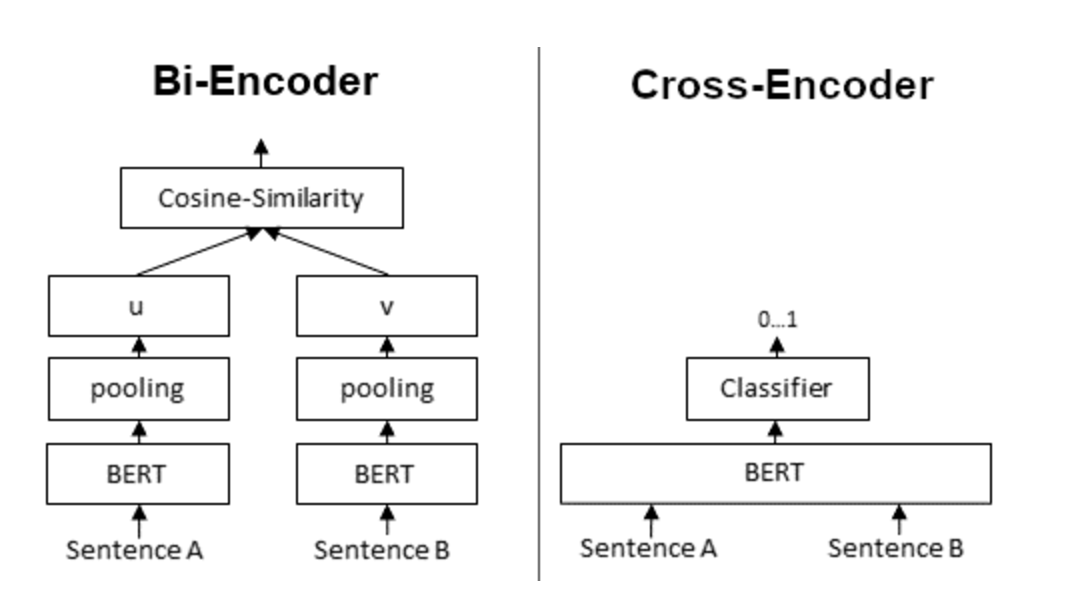

In [37]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [38]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [39]:
# pritn the cross rerank scores
cross_rerank_scores

array([  5.3051004,  -2.78476  ,  -8.846415 ,  -9.803111 ,  -9.563088 ,
        -9.411114 , -10.699626 , -10.723005 , -10.450984 , -10.410948 ],
      dtype=float32)

In [40]:
results_df['Reranked_scores'] = cross_rerank_scores

In [41]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Page_No.': 'Page 20'},Section B - Premiums Article 1 - Payment Respo...,1.082573,19,5.305100
1,{'Page_No.': 'Page 23'},Section C - Policy Termination Article 1 - Fai...,1.185528,22,-2.784760
2,{'Page_No.': 'Page 43'},Any individual policy issued will then be in f...,1.217720,42,-8.846415
3,{'Page_No.': 'Page 33'},a . In no event will Dependent Life Insurance ...,1.249541,32,-9.803111
4,{'Page_No.': 'Page 26'},PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,1.267903,25,-9.563088
5,{'Page_No.': 'Page 36'},A Member's insurance under this Group Policy f...,1.295481,35,-9.411114
6,{'Page_No.': 'Page 28'},Section B - Effective Dates Article 1 - Member...,1.299358,27,-10.699626
7,{'Page_No.': 'Page 21'},b . on any date the definition of Member or De...,1.316056,20,-10.723005
8,{'Page_No.': 'Page 38'},Section D - Continuation Article 1 - Member Li...,1.319336,37,-10.450984
9,{'Page_No.': 'Page 30'},"(6) If, on the date a Member becomes eligible ...",1.325359,29,-10.410948


In [42]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Page_No.': 'Page 20'},Section B - Premiums Article 1 - Payment Respo...,1.082573,19,5.305100
1,{'Page_No.': 'Page 23'},Section C - Policy Termination Article 1 - Fai...,1.185528,22,-2.784760
2,{'Page_No.': 'Page 43'},Any individual policy issued will then be in f...,1.217720,42,-8.846415


In [43]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Page_No.': 'Page 20'},Section B - Premiums Article 1 - Payment Respo...,1.082573,19,5.305100
1,{'Page_No.': 'Page 23'},Section C - Policy Termination Article 1 - Fai...,1.185528,22,-2.784760
2,{'Page_No.': 'Page 43'},Any individual policy issued will then be in f...,1.217720,42,-8.846415


In [44]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
0,Section B - Premiums Article 1 - Payment Respo...,{'Page_No.': 'Page 20'}
1,Section C - Policy Termination Article 1 - Fai...,{'Page_No.': 'Page 23'}
2,Any individual policy issued will then be in f...,{'Page_No.': 'Page 43'}


## Retrieval Augmented Generation


Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [45]:
# Set the API key
key_path = "/content/drive/MyDrive/openai/openai_api_key.txt"
with open(key_path, "r") as f:
  openai_api_key = f.read().strip()
openai.api_key = openai_api_key

In [46]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):

    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [57]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [58]:
# Print the response
print("\n".join(response))

The grace period allowed for insurance policies mentioned in the documents provided is 30 days.

**Citations:**
1. Policy Name: Section B - Premiums  
   Page Number: Page 20

2. Policy Name: Section C - Policy Termination  
   Page Number: Page 23


## Queries

In [50]:
def search(query):

  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()

  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )

  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        results = collection.query(
        query_texts=query,
        n_results=10
        )

        Keys = []
        Values = []

        size = len(results.items())

        for key, val in results.items():
          if val is None:
            continue
          for i in range(size):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],
            metadatas = dict(zip(Keys, Values))
        )


        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        return results_df



  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)


        return pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadatas': metadatas
        })

In [51]:
def apply_cross_encoder(query, df):
  cross_inputs = [[query, response] for response in df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)
  df['Reranked_scores'] = cross_rerank_scores
  return df

In [52]:
def get_topn(n, df):
  top_3_rerank = df.sort_values(by='Reranked_scores', ascending=False)
  return top_3_rerank[["Documents", "Metadatas"]][:n]

### Test queries and their results

In [70]:
# First Query
query1 = 'How many days of grace period is allowed'
df1 = search(query1)
df1 = apply_cross_encoder(query1, df1)
df1 = get_topn(3, df1)

In [71]:
# First query top 3 results
print(df1)

                                           Documents                Metadatas
0  Section B - Premiums Article 1 - Payment Respo...  {'Page_No.': 'Page 20'}
1  Section C - Policy Termination Article 1 - Fai...  {'Page_No.': 'Page 23'}
2  Any individual policy issued will then be in f...  {'Page_No.': 'Page 43'}


In [72]:
# First Query LLM Response
response1 = generate_response(query1, df1)
print("\n".join(response1))

The grace period allowed for premium payment is 30 days. This information is found in the 'Section B - Premiums Article 1 - Payment Responsibilities' document on Page 20.
Citation:
- Policy Name: Section B - Premiums Article 1 - Payment Responsibilities
- Page Number: Page 20


In [73]:
# Second Query
query2 = 'what is the proof of ADL disability or total disability ?'
df2 = search(query2)
df2 = apply_cross_encoder(query2, df2)
df2 = get_topn(3, df2)

In [74]:
# Second query top 3 results
print(df2)

                                           Documents                Metadatas
1  The Principal may require that a ADL Disabled ...  {'Page_No.': 'Page 50'}
0  Payment of benefits will be subject to the Ben...  {'Page_No.': 'Page 49'}
2  Coverage During Disability will cease on the e...  {'Page_No.': 'Page 51'}


In [75]:
# Second Query LLM Response
response2 = generate_response(query2, df2)
print("\n".join(response2))

The proof of ADL (Activities of Daily Living) disability or total disability is typically demonstrated through a combination of medical records, functional assessments, and possibly employer documents for total disability claims. Specific requirements may vary based on the insurance policy you have. Please refer to the policy document titled "Section B - Premiums Article 1 - Payment Responsibility" on page 20 for detailed information on the proof of ADL or total disability.

In case you need more detailed guidelines or specific forms for submitting the proof of disability, it is recommended to review the policy document mentioned above for comprehensive instructions and contact your insurance provider for further assistance.

Here are the relevant details for the citation:
- Policy Name: Section B - Premiums Article 1 - Payment Responsibility
- Page Number: Page 20

In case you need additional information or have further questions, feel free to reach out to your insurance provider for 

In [79]:
# Third Query
query3 = 'When the proof of good health is not required ?'
df3 = search(query3)
df3 = apply_cross_encoder(query3, df3)
df3 = get_topn(3, df3)

In [80]:
# Third query top 3 results
print(df3)

                                           Documents                Metadatas
0  Insurance for which Proof of Good Health is re...  {'Page_No.': 'Page 29'}
2  Scheduled Benefit in force for the Member befo...  {'Page_No.': 'Page 31'}
3  a. be actively engaged in business for profit ...  {'Page_No.': 'Page 17'}


In [81]:
# Third Query LLM Response
response3 = generate_response(query3, df3)
print("\n".join(response3))

Proof of good health is typically not required when applying for a guaranteed issue life insurance policy. These types of policies do not require any medical exams or health questionnaires, making them accessible to individuals who may have pre-existing health conditions.

Unfortunately, the provided documents do not seem to contain specific information regarding when proof of good health is not required. It's recommended to review the sections related to underwriting guidelines, policy eligibility, or medical requirements in the policy documents to obtain detailed information on when proof of good health is not necessary.

Here is the relevant information from the data frame:

| Policy Name                                      | Page Number |
|--------------------------------------------------|-------------|
| Section B - Premiums                             | Page 20     |
| Section C - Policy Termination                   | Page 23     |
| Individual Policy Issuance Details         